ACV decomposition under assumption of access to log-likelihoods of different fidelities while retaining the global kernel with quadratic complexity.

In [356]:
import os
import re
import numpy as np
import torch
import torch.distributions as tdst
import scipy
from scipy.spatial.distance import pdist, squareform
from scipy.stats import multivariate_normal
from scipy.stats import qmc
import numpy.matlib as nm

from mxmc import Optimizer

from rich.progress import track

In [357]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rc("axes.spines", right=True, top=True)
plt.rc("figure",
      #  dpi=150,
      #  figsize=(9, 3)
      )
plt.rc("font", family="serif")
plt.rc("legend", edgecolor="none", frameon=True)
plt.style.use("dark_background")

marker_symbol = u'\u2B2C'

In [358]:
mu_oracle_hf = np.array([0.6, 0.1])
cov_oracle_hf = np.array([[2.0, 0.4], [0.4, 0.5]])

mu_oracle_lf1 = np.array([0.8, 0.32])
cov_oracle_lf1 = np.array([[1.5, 0.35], [0.35, 0.5]])

mu_oracle_lf2 = np.array([0.3, -0.1])
cov_oracle_lf2 = np.array([[1.5, 0.0], [0.0, 0.3]])


In [359]:
def autodiff_log_prob(log_prob_fn):
    """
    Wraps a log probability function to return both the (log_prob, grad_log_prob).
    log_prob_fn: Return the log probability for a tensor input.
    """
    def wrapped(theta):
        theta =  torch.as_tensor(theta, dtype=torch.float32).clone().detach().requires_grad_(True)
        log_prob = log_prob_fn(theta)
        grad_log_prob = torch.autograd.grad(log_prob.sum(), theta)[0]
        return grad_log_prob.detach().numpy()
    
    return wrapped


In [360]:
def mvn_dlnprob_hf(theta, mu, cov):
    return -1*np.matmul(theta-nm.repmat(mu, theta.shape[0], 1),
                        np.linalg.inv(cov))

def mvn_dlnprob_lf(theta, mu, cov):
    return -1*np.matmul(theta-nm.repmat(mu, theta.shape[0], 1),
                        np.linalg.inv(cov))

def mvn_dlnprob_hf2(theta, mu, cov):
    # Subtract mu from each row of theta via broadcasting.
    diff = theta - mu
    # Solve cov * x = diff.T for x; 
    # then x.T gives diff @ inv(cov)
    grad = -np.linalg.solve(cov, diff.T).T
    return grad

def dlnprob_neals_hf(theta, sigma_z):
    x = theta[:, 0]
    z = theta[:, 1]
    
    return np.stack((-np.divide(x, np.exp(z)), (-z/sigma_z**2 + x**2/(2 * np.exp(z)) - (1/2))), axis=0).T

In [361]:
# Verify that torch.autograd is correctly implemented!
# dlnprob_neals_hf(xzgrid, 3)
# dlnneal_auto = autodiff_log_prob(funnel0_log_prob)
# dlnneal_auto(xzgrid)
# np.sum(np.isclose(dlnneal_auto(xzgrid), dlnprob_neals_hf(xzgrid, 3), atol=1e-4))

# grad1 = mvn_dlnprob_hf(xygrid, mu_oracle_hf, cov_oracle_hf)
# dlnprob_auto = autodiff_log_prob(lnprob0_gaussian)
# np.sum(np.isclose(dlnprob_auto(xygrid), grad1.detach().numpy()))

# np.sum(np.isclose(mvn_dlnprob_hf2(xygrid, mu_oracle_hf, cov_oracle_hf), 
#            mvn_dlnprob_hf(xygrid, mu_oracle_hf, cov_oracle_hf).detach().numpy()))

In [362]:
def lnprob0_gaussian(theta):
    dist_gaussian = tdst.MultivariateNormal(torch.from_numpy(mu_oracle_hf), 
                                            torch.from_numpy(cov_oracle_hf)
                                           )
    
    return dist_gaussian.log_prob(theta)

def lnprob1_gaussian(theta):
    dist_gaussian = tdst.MultivariateNormal(torch.from_numpy(mu_oracle_lf1), 
                                            torch.from_numpy(cov_oracle_lf1)
                                           )
    
    return dist_gaussian.log_prob(theta)


def lnprob2_gaussian(theta):
    mvn_1 = tdst.MultivariateNormal(torch.from_numpy(mu_oracle_lf1),
                                       torch.from_numpy(cov_oracle_lf1))

    mvn_2 = tdst.MultivariateNormal(torch.from_numpy(mu_oracle_lf2),
                                           torch.from_numpy(cov_oracle_lf2))
    
    
    
    density_gauss_1 = mvn_1.log_prob(theta)
    
    density_g2_raw = mvn_2.log_prob(theta)
    density_gauss_2 = torch.log(0.15 * density_gauss_1.exp() + 0.85 * density_g2_raw.exp())
    
    return density_gauss_2

In [363]:
def funnel0_log_prob(theta):
    z = theta[:, 1]
    x = theta[:, 0]
    log_pz = tdst.Normal(0.0, 3.0).log_prob(z)
    log_px_given_z = tdst.Normal(0.0, (z / 2.0).exp()).log_prob(x)
    return log_pz + log_px_given_z


def funnel1_log_prob(theta):
    z = theta[:, 1]
    x = theta[:, 0]
    log_pz = tdst.Normal(0.0, 3.0).log_prob(z)
    log_px_given_z = tdst.Normal(0.0, (z / 1.5).exp()).log_prob(x)
    return log_pz + log_px_given_z

def funnel2_log_prob(theta):
    z = theta[:, 1]
    x = theta[:, 0]
    log_pz = tdst.Normal(0.0, 3.0).log_prob(z)
    log_px_given_z = tdst.Normal(0.0, (z / 0.7).exp()).log_prob(x)
#     log_px_given_z = tdst.Normal(0.0, 1 + 0.5 * z**2).log_prob(x)
    return log_pz + log_px_given_z


xs, zs = torch.meshgrid(
    torch.arange(-50, 50, 0.1),
    torch.arange(-15.0, 15.0, 0.1),
)

xzgrid = torch.stack([xs.flatten(), zs.flatten()], dim=1)

In [364]:
class SVGD():
    """
    Adapted from DartML implementation with minor changes.
    """
    def __init__(self):
        pass
        

    def svgd_kernel(self, theta, h = -1):
        sq_dist = pdist(theta)
        pairwise_dists = squareform(sq_dist)**2
        if h < 0: # if h < 0, using median trick
            h = np.median(pairwise_dists)
            h = np.sqrt(0.5 * h / np.log(theta.shape[0]+1))

        # compute the rbf kernel
        Kxy = np.exp( -pairwise_dists / h**2 / 2)

        dxkxy = -np.matmul(Kxy, theta)
        sumkxy = np.sum(Kxy, axis=1)
        for i in range(theta.shape[1]):
            dxkxy[:, i] = dxkxy[:,i] + np.multiply(theta[:,i],sumkxy)
        dxkxy = dxkxy / (h**2)
        return (Kxy, dxkxy, h)
    

    def update_grad(self, theta_all, lnprob,
               n_iter = 1000,
               stepsize = 1e-3,
               bandwidth = -1,
               alpha = 0.9,
               return_all = False,
               debug = False):
        
        """
        Using particle positions calculated via High-fidelity likelihood updates, find the corresponding gradients 
        if the low fidelity particles had been used. That way, the likelihoods and the gradients can be CORRECTLY
        correlated.
        """
        # Check input
        if lnprob is None:
            raise ValueError('lnprob cannot be None!')

        # adagrad with momentum
        fudge_factor = 1e-6
        historical_grad = 0
        adj_grads = []
        vn_grads = []
        lnpgrad_inter = np.zeros((theta_all.shape[0], theta_all.shape[1], n_iter))
        for itn in track(range(n_iter), description="Running iterations for particle position updates..."):
            if debug and (itn+1) % 1000 == 0:
                print('iter ' + str(itn+1))

            lnpgrad = lnprob(theta_all[:, :, itn])
            lnpgrad_inter[:, :, itn] = lnpgrad

            kxy, dxkxy, h = self.svgd_kernel(theta_all[:, :, itn], h=-1)
            grad_theta = (np.matmul(kxy, lnpgrad) + dxkxy) / theta_all.shape[0]
#             lengthscales_all[itn] = h

            
            if itn == 0:
                historical_grad = historical_grad + grad_theta ** 2
            else:
                historical_grad = alpha * historical_grad + (1 - alpha) * (grad_theta ** 2)
            adj_grad = np.divide(grad_theta, fudge_factor+np.sqrt(historical_grad))
            
            adj_grads.append(adj_grad)
            vn_grads.append(grad_theta)
            
        return lnpgrad_inter, adj_grads, vn_grads
    
    def update(self, x0, lnprob,
               n_iter = 1000,
               stepsize = 1e-3,
               bandwidth = -1,
               alpha = 0.9,
               return_all = False,
               debug = False):
        # Check input
        if x0 is None or lnprob is None:
            raise ValueError('x0 or lnprob cannot be None!')

        theta_all = np.zeros((x0.shape[0], x0.shape[1], n_iter))
        lengthscales_all = np.zeros(n_iter)
        theta = np.copy(x0)
        lnpgrad_inter = np.zeros((x0.shape[0], x0.shape[1], n_iter))

        fudge_factor = 1e-6
        historical_grad = 0
        kxy_final = []
        dxkxy_final = []
        lnpgrad_final = []
        adj_grads = []
        vn_grads = []
        for itn in track(range(n_iter), description="Running iterations for particle position updates..."):
            if debug and (itn+1) % 1000 == 0:
                print('iter ' + str(itn+1))

            lnpgrad = lnprob(theta)
            lnpgrad_inter[:, :, itn] = lnpgrad
            # calculating the kernel matrix
            kxy, dxkxy, h = self.svgd_kernel(theta, h=-1)
            grad_theta = (np.matmul(kxy, lnpgrad) + dxkxy) / x0.shape[0]

            lengthscales_all[itn] = h

            # adagrad
            if itn == 0:
                historical_grad = historical_grad + grad_theta ** 2
            else:
                historical_grad = alpha * historical_grad + (1 - alpha) * (grad_theta ** 2)
            adj_grad = np.divide(grad_theta, fudge_factor+np.sqrt(historical_grad))
            
            theta = theta + stepsize * grad_theta
#             theta = theta + stepsize * adj_grad

            adj_grads.append(adj_grad)
            vn_grads.append(grad_theta)
            theta_all[:, :, itn] = theta
            if itn == n_iter - 1:
                kxy_final = kxy
                dxkxy_final = dxkxy
                lnpgrad_final = lnpgrad
        if return_all:
            return theta_all, lengthscales_all, kxy_final, dxkxy_final, lnpgrad_final, adj_grads, vn_grads, lnpgrad_inter
        else:
            return theta
        
    @staticmethod
    def get_step_size(epsilon_0, lambda_, t):
        return epsilon_0 / (1 + lambda_ * t)

In [365]:
xvec, yvec = torch.arange(-4.0, 4.0, 0.1), torch.arange(-4.0, 4.0, 0.1)
xg, yg = torch.meshgrid(xvec, yvec)

xygrid = torch.stack([xg.flatten(), yg.flatten()], dim=1)

mvn_0 = tdst.MultivariateNormal(torch.from_numpy(mu_oracle_hf),
                                       torch.from_numpy(cov_oracle_hf))

mvn_1 = tdst.MultivariateNormal(torch.from_numpy(mu_oracle_lf1),
                                       torch.from_numpy(cov_oracle_lf1))

mvn_2 = tdst.MultivariateNormal(torch.from_numpy(mu_oracle_lf2),
                                       torch.from_numpy(cov_oracle_lf2))


density_gauss_0 = mvn_0.log_prob(xygrid).reshape(xg.shape)
density_gauss_1 = mvn_1.log_prob(xygrid).reshape(xg.shape)
density_g2_raw = mvn_2.log_prob(xygrid).reshape(xg.shape)

density_gauss_2 = torch.log(0.15 * density_gauss_1.exp() + 0.85 * density_g2_raw.exp())



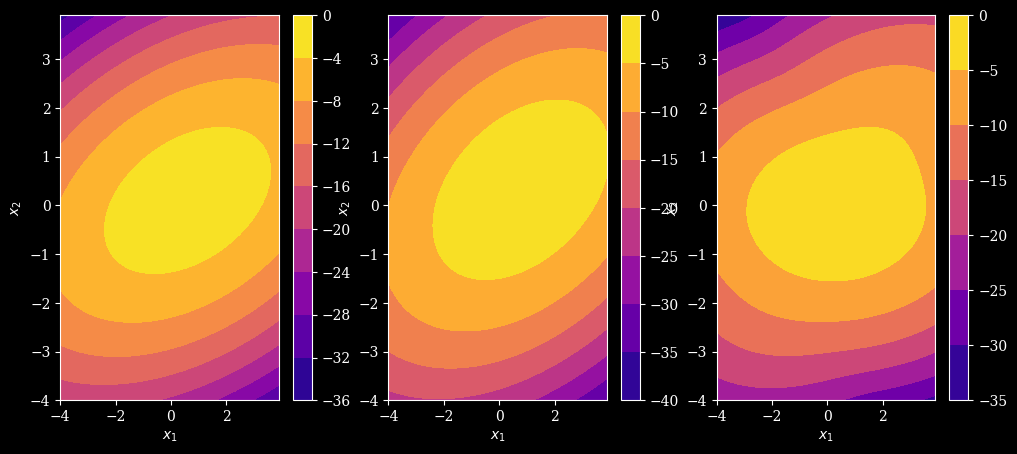

In [366]:
fig, ax = plt.subplots(1, 3, figsize=(12, 5))
c0 = ax[0].contourf(xg, yg, 
          density_gauss_0, 
          cmap="plasma"
         )
ax[0].set_xlabel(r"$x_1$")
ax[0].set_ylabel(r"$x_2$")
fig.colorbar(c0, ax=ax[0])


c1 = ax[1].contourf(xg, yg, 
          density_gauss_1, 
          cmap="plasma"
         )
ax[1].set_xlabel(r"$x_1$")
ax[1].set_ylabel(r"$x_2$")
fig.colorbar(c1, ax=ax[1])

c2 = ax[2].contourf(xg, yg, 
          density_gauss_2, 
          cmap="plasma"
         )
ax[2].set_xlabel(r"$x_1$")
ax[2].set_ylabel(r"$x_2$")
fig.colorbar(c2, ax=ax[2])

In [367]:
xs, zs = torch.meshgrid(
    torch.arange(-50, 50, 0.1),
    torch.arange(-15.0, 15.0, 0.1),
)

xzgrid = torch.stack([xs.flatten(), zs.flatten()], dim=1)

density_neal_0 = (
    tdst.Normal(0.0, (zs / 2.0).exp()).log_prob(xs).exp()
    * tdst.Normal(0.0, 3.0).log_prob(zs).exp()
)

density_neal_1 = (
    tdst.Normal(0.0, (zs / 1.5).exp()).log_prob(xs).exp()
    * tdst.Normal(0.0, 3.0).log_prob(zs).exp()
)

density_neal_2 = (
    tdst.Normal(0.0, (zs / 0.7).exp()).log_prob(xs).exp()
#     tdst.Normal(0.0, 1 + 0.5 * zs**2).log_prob(xs).exp()
    * tdst.Normal(0.0, 3.0).log_prob(zs).exp()
)

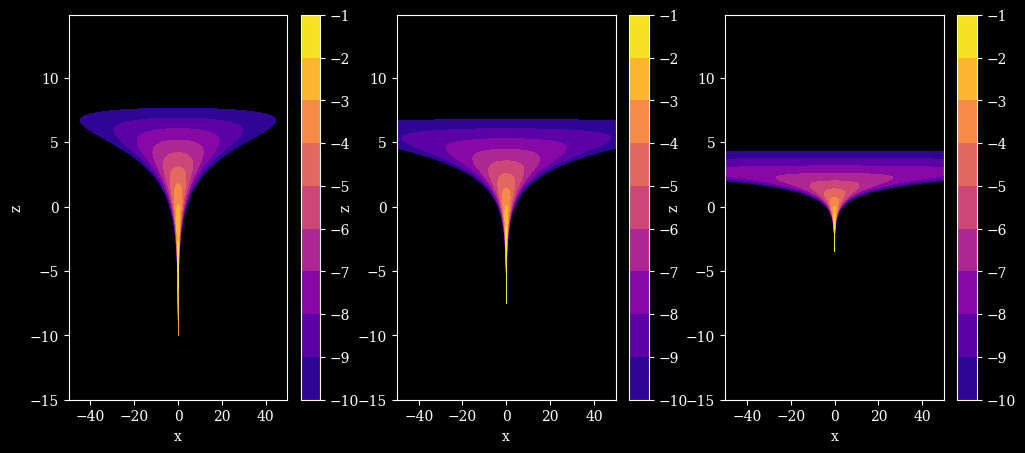

In [368]:
fig, ax = plt.subplots(1, 3, figsize=(12, 5))
c0 = ax[0].contourf(xs, zs, 
          density_neal_0.log(), 
          levels=range(-10, 0),
          cmap="plasma"
         )
ax[0].set_xlabel("x")
ax[0].set_ylabel("z")
fig.colorbar(c0, ax=ax[0])


c1 = ax[1].contourf(xs, zs, 
          density_neal_1.log(), 
          levels=range(-10, 0),
          cmap="plasma"
         )
ax[1].set_xlabel("x")
ax[1].set_ylabel("z")
fig.colorbar(c1, ax=ax[1])

c2 = ax[2].contourf(xs, zs, 
          density_neal_2.log(), 
          levels=range(-10, 0),
          cmap="plasma"
         )
ax[2].set_xlabel("x")
ax[2].set_ylabel("z")
fig.colorbar(c2, ax=ax[2])

In [369]:
N_PARTICLES = 128
torch.manual_seed(2025)

# sampler = qmc.Sobol(d=2, scramble=False)
# initial_particles = sampler.random(n=N_PARTICLES)

# # rescale initial points to lie within -1, 1
# initial_particles = 2 * initial_particles - 1

initial_particles = torch.normal(0.0, 1.0, size=(N_PARTICLES, 2))
# initial_particles

In [370]:
gsvgd = SVGD()
post_gauss_hf, ls_all_hf, kxy_ghf, dxkxy_ghf, lnpgrad_ghf, adj_grads_ghf, vn_grads_ghf, lnpgrad_inter_ghf = gsvgd.update(initial_particles,
                                autodiff_log_prob(lnprob0_gaussian),
#                                                         n_iter=2500,
                                n_iter=7500,                                                                
                                stepsize=0.1,
                                return_all=True)

final_gauss_hf = post_gauss_hf[:, :, -1]

Output()

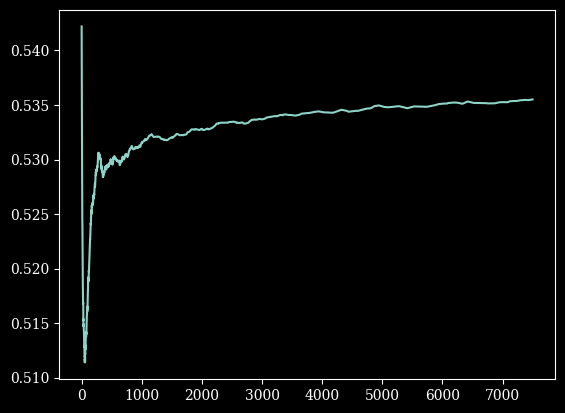

In [371]:
plt.plot(ls_all_hf)

Text(0.5, 1.0, 'Converged Particles')

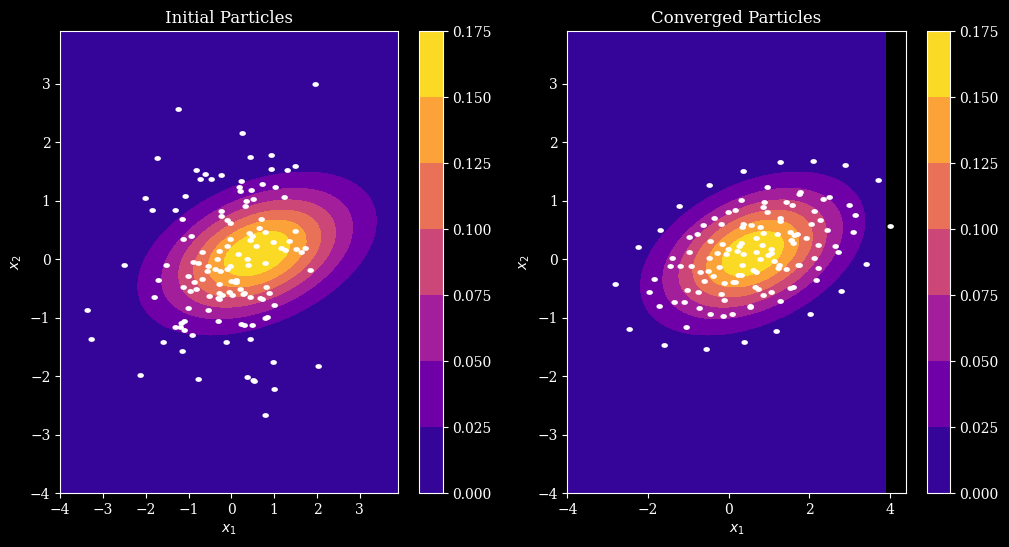

In [372]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
c0 = ax[0].contourf(xg, yg, 
          density_gauss_0.exp(), 
          cmap="plasma"
         )

ax[0].scatter(initial_particles[:, 0], 
           initial_particles[:, 1],
           color="white",
           marker="$%s$" % marker_symbol,
           s=15,
           clip_on=False)

ax[0].set_xlabel(r"$x_1$")
ax[0].set_ylabel(r"$x_2$")

fig.colorbar(c0, ax=ax[0])
ax[0].set_title("Initial Particles")

c1 = ax[1].contourf(xg, yg, 
          density_gauss_0.exp(), 
          cmap="plasma"
         )

ax[1].scatter(final_gauss_hf[:, 0], 
           final_gauss_hf[:, 1],
           color="white",
           marker="$%s$" % marker_symbol,
           s=15,
           clip_on=False)

ax[1].set_xlabel(r"$x_1$")
ax[1].set_ylabel(r"$x_2$")

fig.colorbar(c1, ax=ax[1])
ax[1].set_title("Converged Particles")

In [373]:
nealsvgd = SVGD()
post_neal_hf, ls_neal_hf, kxy_nhf, dxkxy_nhf, lnpgrad_nhf, adj_grads_nhf, vn_grads_nhf, lnpgrad_inter_nhf = nealsvgd.update(initial_particles,
                                                        autodiff_log_prob(funnel0_log_prob),
                                                        n_iter=4000,
                                                        stepsize=0.08,
                                                        return_all=True)

final_neal_hf = post_neal_hf[:, :, -1]

Output()

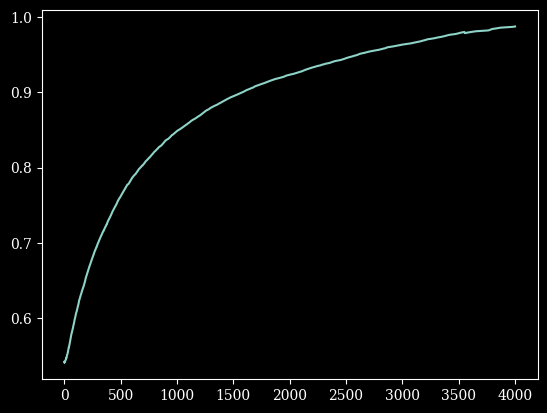

In [374]:
plt.plot(ls_neal_hf)

Text(0.5, 1.0, 'Converged Particles')

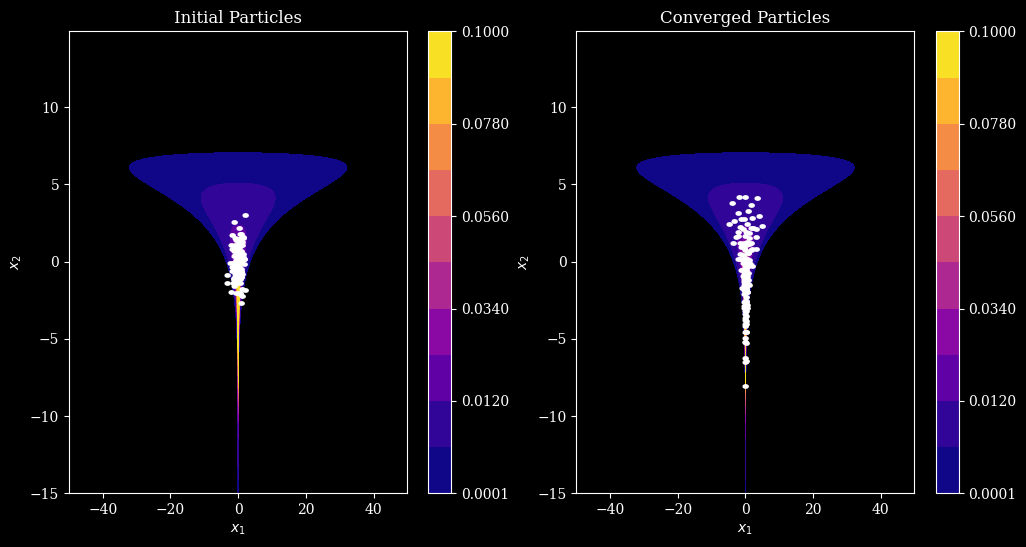

In [375]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
c0 = ax[0].contourf(xs, zs, 
          density_neal_0, 
#           levels=range(-10, 0),
        levels=[0.0001] + torch.linspace(0.001, 0.1, 10).tolist(),
          cmap="plasma"
         )

ax[0].scatter(initial_particles[:, 0], 
           initial_particles[:, 1],
           color="white",
           marker="$%s$" % marker_symbol,
           s=15,
           clip_on=False)

ax[0].set_xlabel(r"$x_1$")
ax[0].set_ylabel(r"$x_2$")

fig.colorbar(c0, ax=ax[0])
ax[0].set_title("Initial Particles")

c1 = ax[1].contourf(xs, zs, 
          density_neal_0, 
#           levels=range(-10, 0),
        levels=[0.0001] + torch.linspace(0.001, 0.1, 10).tolist(),
          cmap="plasma"
         )

ax[1].scatter(final_neal_hf[:, 0], 
           final_neal_hf[:, 1],
           color="white",
           marker="$%s$" % marker_symbol,
           s=15,
           clip_on=False)

ax[1].set_xlabel(r"$x_1$")
ax[1].set_ylabel(r"$x_2$")

fig.colorbar(c1, ax=ax[1])
ax[1].set_title("Converged Particles")

In order to proceed with the ACV-like framework, we change a few things - for one, Adagrad which can help quick convergence is set aside for 
vanilla gradient descent with fixed stepsize (already implemented in the above plots). This is because the previous case accumulates a nonlinear function of the gradients to adapt the stepsize, and this messes up both the correlations and our ability to actually combine different estimates of the gradient (there are other ways to speed things up without Adagrad, for example using some interesting preconditioning adaptations of SVGD - https://arxiv.org/pdf/1910.12794)

To obtain correlations:

- Take pilot HF particles

- Compute all intermediate positions.

- For each position, obtain corresponding \emph{low-fidelity} gradients according to the appropriate log-likelihood function. (in this setting, the kernel function counts for nothing in the low-fi correlations).

In [376]:
lnpgrad_lf_same1, adj_grads_lf_same1, vn_grads_lf_same1 = gsvgd.update_grad(post_gauss_hf,
                                    autodiff_log_prob(lnprob1_gaussian),
                                    n_iter=7500,
                                    stepsize=0.1,
                                    )


lnpgrad_lf_same2, adj_grads_lf_same2, vn_grads_lf_same2 = gsvgd.update_grad(post_gauss_hf,
                                    autodiff_log_prob(lnprob2_gaussian),
                                    n_iter=7500,
                                    stepsize=0.1,
                                    )

Output()

Output()

In [377]:
lnpgrad_nf_same1, adj_grads_nf_same1, vn_grads_nf_same1 = nealsvgd.update_grad(post_neal_hf,
                                    autodiff_log_prob(funnel1_log_prob),
                                    n_iter=4000,
                                    stepsize=0.08,
                                    )

lnpgrad_nf_same2, adj_grads_nf_same2, vn_grads_nf_same2 = nealsvgd.update_grad(post_neal_hf,
                                    autodiff_log_prob(funnel2_log_prob),
                                    n_iter=4000,
                                    stepsize=0.08,
                                    )

Output()

Output()

Componentwise gradients

In [378]:
def getcorrcovs(grad_0, grad_1, grad_2, n_iter=7500):
    
    covs_gu = np.zeros((3, 3, n_iter))
    covs_gv = np.zeros((3, 3, n_iter))

    cors_gu = np.zeros((3, 3, n_iter))
    cors_gv = np.zeros((3, 3, n_iter))

    grads_hf = np.array(grad_0)
    grads_lf1 = np.array(grad_1)
    grads_lf2 = np.array(grad_2)


    for i in range(n_iter):
        g_u = np.stack((grads_hf[i, :, 0], grads_lf1[i, :, 0], grads_lf2[i, :, 0]))
        g_v = np.stack((grads_hf[i, :, 1], grads_lf1[i, :, 1], grads_lf2[i, :, 1]))

        covs_gu[:, :, i] = np.cov(g_u)
        covs_gv[:, :, i] = np.cov(g_v)


        cors_gu[:, :, i] = np.corrcoef(g_u)
        cors_gv[:, :, i] = np.corrcoef(g_v)
        
    
    return covs_gu, covs_gv, cors_gu, cors_gv

In [379]:
ucov_gauss, vcov_gauss, ucor_gauss, vcor_gauss = getcorrcovs(vn_grads_ghf, 
                                                             vn_grads_lf_same1, 
                                                             vn_grads_lf_same2,
                                                             n_iter=7500)


ucov_neal, vcov_neal, ucor_neal, vcor_neal = getcorrcovs(vn_grads_nhf, 
                                                        vn_grads_nf_same1, 
                                                        vn_grads_nf_same2,
                                                        n_iter=4000)

The setup of the Gaussians is quite forgiving - correlations are consistently high

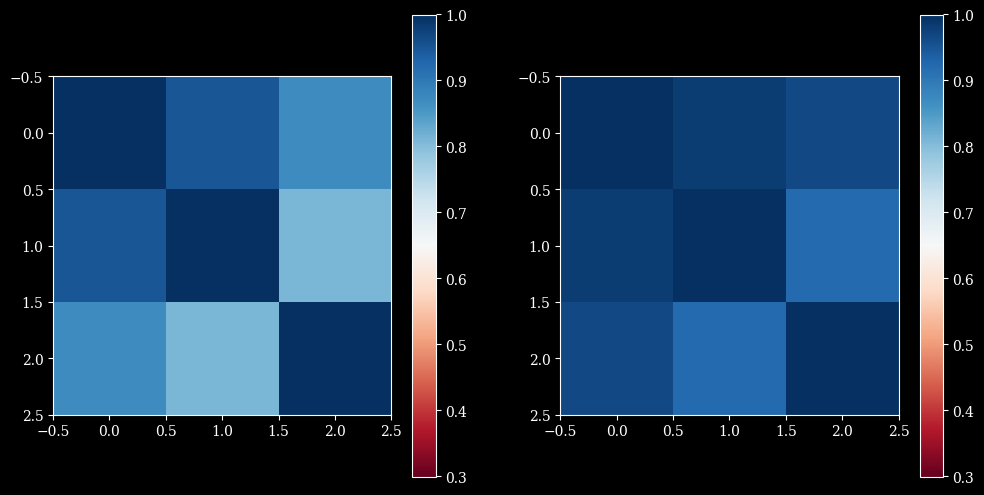

In [380]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
im0 = ax[0].imshow(ucor_gauss[:, :, 0],
          cmap='RdBu',
          vmin=0.3,
          vmax=1.0)
fig.colorbar(im0, ax=ax[0])

im1 = ax[1].imshow(vcor_gauss[:, :, 0],
          cmap='RdBu',
          vmin=0.3,
          vmax=1.0)
fig.colorbar(im1, ax=ax[1])

For the funnel though, its quite clear that the correlations degrade significantly between models as we move towards the direction of the exponential geometry.

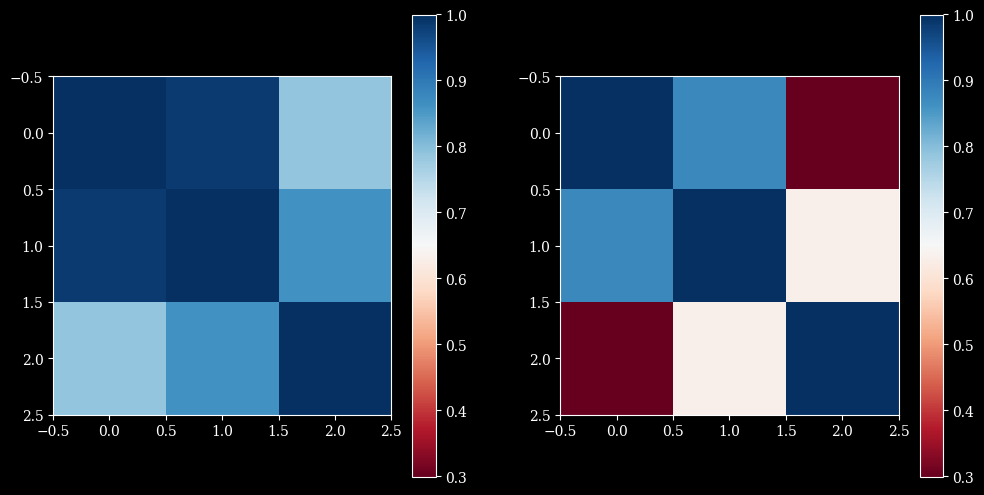

In [381]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
im0 = ax[0].imshow(ucor_neal[:, :, 0],
          cmap='RdBu',
          vmin=0.3,
          vmax=1.0)
fig.colorbar(im0, ax=ax[0])

im1 = ax[1].imshow(vcor_neal[:, :, 0],
          cmap='RdBu',
          vmin=0.3,
          vmax=1.0)
fig.colorbar(im1, ax=ax[1])

As we progress through the iterations, the correlations can get quite poor.

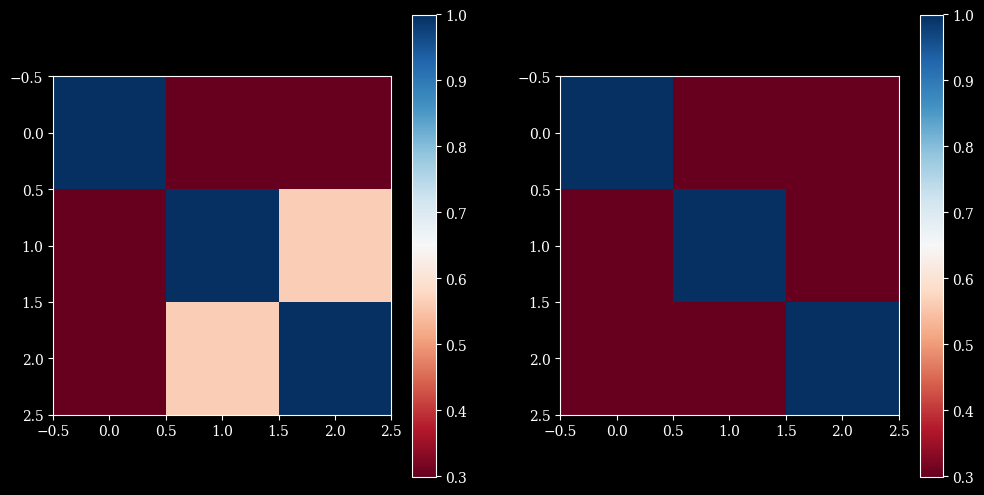

In [382]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
im0 = ax[0].imshow(ucor_gauss[:, :, 1000],
          cmap='RdBu',
          vmin=0.3,
          vmax=1.0)
fig.colorbar(im0, ax=ax[0])

im1 = ax[1].imshow(vcor_gauss[:, :, 1000],
          cmap='RdBu',
          vmin=0.3,
          vmax=1.0)
fig.colorbar(im1, ax=ax[1])

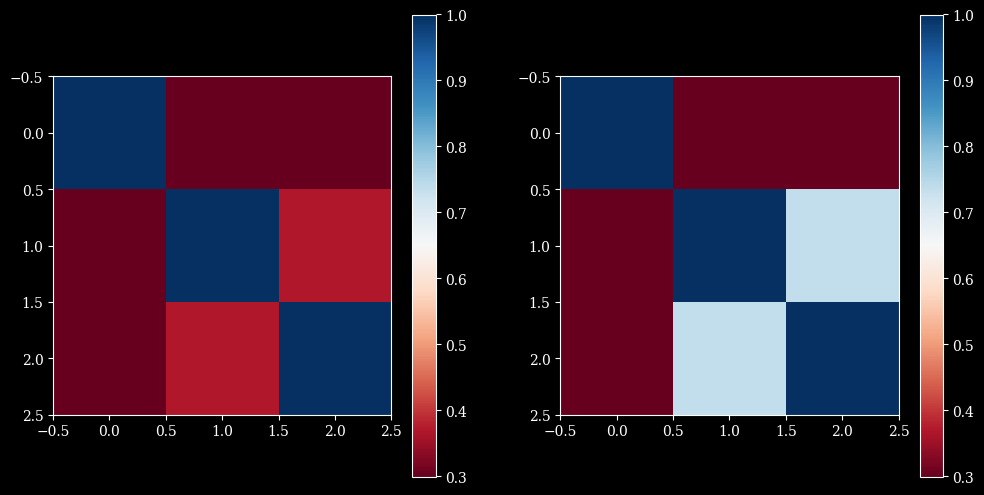

In [383]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
im0 = ax[0].imshow(ucor_neal[:, :, 1000],
          cmap='RdBu',
          vmin=0.3,
          vmax=1.0)
fig.colorbar(im0, ax=ax[0])

im1 = ax[1].imshow(vcor_neal[:, :, 1000],
          cmap='RdBu',
          vmin=0.3,
          vmax=1.0)
fig.colorbar(im1, ax=ax[1])

Text(0.5, 1.0, 'Correlation of gradients over all SVGD updates')

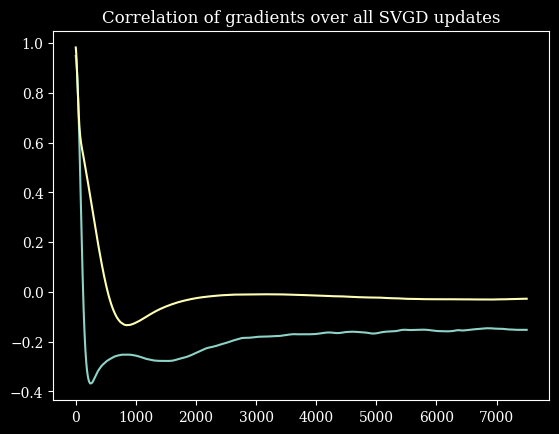

In [384]:
plt.plot(np.linspace(1, 7500, 7500), ucor_gauss[0, 1, :])
plt.plot(np.linspace(1, 7500, 7500), vcor_gauss[0, 1, :])
# plt.plot(2 * ls_all_hf)
# plt.xlim(0, 1000)
plt.title("Correlation of gradients over all SVGD updates")

Text(0.5, 1.0, 'Correlation of gradients over all SVGD updates')

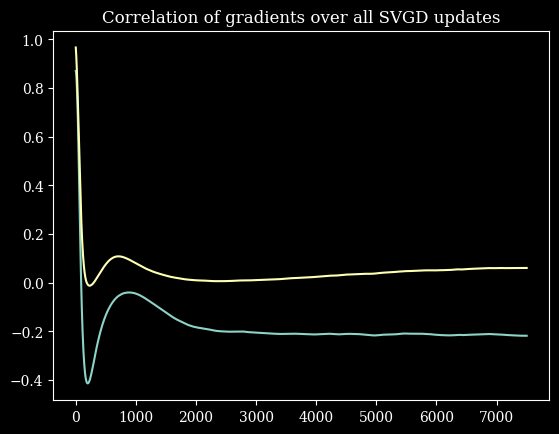

In [385]:
plt.plot(np.linspace(1, 7500, 7500), ucor_gauss[0, 2, :])
plt.plot(np.linspace(1, 7500, 7500), vcor_gauss[0, 2, :])
# plt.xlim(0, 1000)
plt.title("Correlation of gradients over all SVGD updates")

Text(0.5, 1.0, 'Correlation of gradients over all SVGD updates')

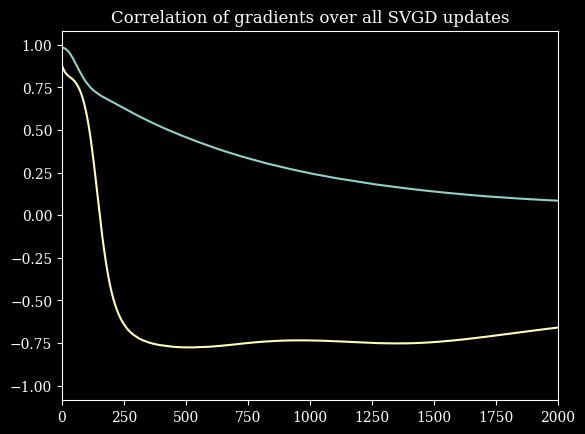

In [386]:
plt.plot(np.linspace(1, 4000, 4000), ucor_neal[0, 1, :])
plt.plot(np.linspace(1, 4000, 4000), vcor_neal[0, 1, :])
plt.xlim(0, 2000)
plt.title("Correlation of gradients over all SVGD updates")

In [387]:
from mxmc import Optimizer
from mxmc import OutputProcessor
from mxmc import Estimator

In [388]:
# Common Cost Vector for Both Benchmark Problems!
costs = np.array([1, 0.25, 0.1])

In [389]:
N_PARTICLES_FINAL = 512
torch.manual_seed(2026)

# sampler = qmc.Sobol(d=2, scramble=False)
# initial_particles = sampler.random(n=N_PARTICLES)

# # rescale initial points to lie within -1, 1
# initial_particles = 2 * initial_particles - 1

# initialize particles to propagate with prior covariance information from pilot sampling.
init_part_prop = torch.normal(0.0, 1.0, size=(N_PARTICLES_FINAL, 2))
# initial_particles

512


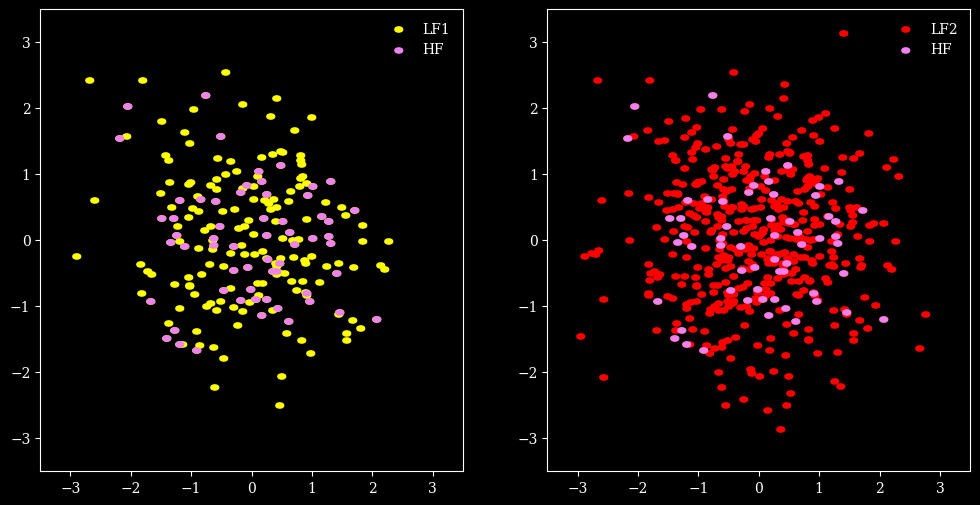

In [390]:
optimizer = Optimizer(costs, ucov_gauss[:, :, 0])
result = optimizer.optimize(algorithm="acvmf", target_cost=164)
allocation = result.allocation
print(allocation.num_total_samples)
model_input_samples = allocation.allocate_samples_to_models(init_part_prop)
hf_alloc = model_input_samples[0]
lf_alloc1 = model_input_samples[1]
lf_alloc2 = model_input_samples[2]

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].scatter(lf_alloc1[:, 0], lf_alloc1[:, 1],
           marker="$%s$" % marker_symbol,
           color="yellow",
           label="LF1")

ax[0].scatter(hf_alloc[:, 0], hf_alloc[:, 1],
           marker="$%s$" % marker_symbol,
           color="violet",
           label="HF")

ax[0].legend()
ax[0].set_ylim(-3.5, 3.5)
ax[0].set_xlim(-3.5, 3.5)


ax[1].scatter(lf_alloc2[:, 0], lf_alloc2[:, 1],
           marker="$%s$" % marker_symbol,
           color="red",
           label="LF2")


ax[1].scatter(hf_alloc[:, 0], hf_alloc[:, 1],
           marker="$%s$" % marker_symbol,
           color="violet",
           label="HF")
ax[1].set_ylim(-3.5, 3.5)
ax[1].set_xlim(-3.5, 3.5)


ax[1].legend()

In [395]:
hf_alloc.shape, lf_alloc1.shape, lf_alloc2.shape

(torch.Size([121, 2]), torch.Size([122, 2]), torch.Size([123, 2]))

123


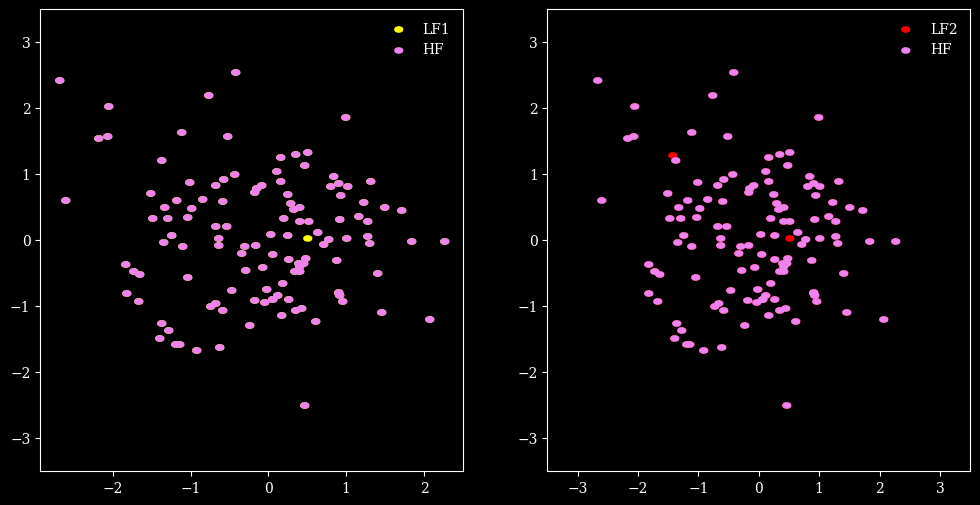

In [394]:
optimizer = Optimizer(costs, ucov_gauss[:, :, 1000])
result = optimizer.optimize(algorithm="acvmf", target_cost=164)
allocation = result.allocation
print(allocation.num_total_samples)
model_input_samples = allocation.allocate_samples_to_models(init_part_prop)
hf_alloc = model_input_samples[0]
lf_alloc1 = model_input_samples[1]
lf_alloc2 = model_input_samples[2]

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].scatter(lf_alloc1[:, 0], lf_alloc1[:, 1],
           marker="$%s$" % marker_symbol,
           color="yellow",
           label="LF1")

ax[0].scatter(hf_alloc[:, 0], hf_alloc[:, 1],
           marker="$%s$" % marker_symbol,
           color="violet",
           label="HF")

ax[0].legend()
ax[0].set_ylim(-3.5, 3.5)
ax[1].set_xlim(-3.5, 3.5)


ax[1].scatter(lf_alloc2[:, 0], lf_alloc2[:, 1],
           marker="$%s$" % marker_symbol,
           color="red",
           label="LF2")


ax[1].scatter(hf_alloc[:, 0], hf_alloc[:, 1],
           marker="$%s$" % marker_symbol,
           color="violet",
           label="HF")
ax[1].set_ylim(-3.5, 3.5)
ax[1].set_xlim(-3.5, 3.5)


ax[1].legend()

In [ ]:
class SVGDMF():
    """
    A multifidelity gradient estimate.
    """
    def __init__(self):
        pass
        

    def svgd_kernel(self, theta, h = -1):
        sq_dist = pdist(theta)
        pairwise_dists = squareform(sq_dist)**2
        if h < 0: # if h < 0, using median trick
            h = np.median(pairwise_dists)
            h = np.sqrt(0.5 * h / np.log(theta.shape[0]+1))

        # compute the rbf kernel
        Kxy = np.exp(-pairwise_dists / h**2 / 2)

        dxkxy = -np.matmul(Kxy, theta)
        sumkxy = np.sum(Kxy, axis=1)
        for i in range(theta.shape[1]):
            dxkxy[:, i] = dxkxy[:,i] + np.multiply(theta[:,i],sumkxy)
        dxkxy = dxkxy / (h**2)
        return (Kxy, dxkxy, h)
    
    
#     def precompute_allocations(self, cov_tensor, costs, n_iter=1000):
#         assert cov_tensor.shape[2] == n_iter
    
    
    def construct_mf_update(self, x0, lnprobs,
                           cov_tensor,
                           n_iter=1000,
                           stepsize=1e-3,
                           bandwidth=-1,
                           alpha=0.9,
                           return_all=False,
                           debug=False):
        
        """
        Pass list of lnprobs instead of a single function. We should be able to 
        precompute allocations too.
        """
        
        
        
        if x0 is None or lnprob is None:
            raise ValueError('x0 or lnprob cannot be None!')

#         theta_all = np.zeros((x0.shape[0], x0.shape[1], n_iter))
        theta = np.copy(x0)
    
        allocations = []
    
        for itn in track(range(n_iter), description="Running iterations for particle position updates..."):
            optimizer = Optimizer(costs, cov_tensor[:, :, i])
            result = optimizer.optimize(algorithm="acvmf", target_cost=164)
            allocation = result.allocation
            
            model_input_samples = allocation.allocate_samples_to_models(init_part_prop)
            
            model_outputs = list()
            
            for input_sample, model, lnpr in zip(model_input_samples, models, lnprobs):
                model_outputs.append(model.evaluate(input_sample))
    
    @staticmethod
    def hfgrad(model_input_samples, model_lnprob):
        
    
    @staticmethod
    def lfgrad1(model_input_samples, model_lnprob):
        
    
    @staticmethod
    def lfgrad2(model_input_samples, model_lnprob):
    
    
    def update(self, x0, lnprob,
               n_iter = 1000,
               stepsize = 1e-3,
               bandwidth = -1,
               alpha = 0.9,
               return_all = False,
               debug = False):
        # Check input
        if x0 is None or lnprob is None:
            raise ValueError('x0 or lnprob cannot be None!')

        theta_all = np.zeros((x0.shape[0], x0.shape[1], n_iter))
        lengthscales_all = np.zeros(n_iter)
        theta = np.copy(x0)
        lnpgrad_inter = np.zeros((x0.shape[0], x0.shape[1], n_iter))

        fudge_factor = 1e-6
        historical_grad = 0
        kxy_final = []
        dxkxy_final = []
        lnpgrad_final = []
        adj_grads = []
        vn_grads = []
        for itn in track(range(n_iter), description="Running iterations for particle position updates..."):
            if debug and (itn+1) % 1000 == 0:
                print('iter ' + str(itn+1))

            lnpgrad = lnprob(theta)
            lnpgrad_inter[:, :, itn] = lnpgrad
            # calculating the kernel matrix
            kxy, dxkxy, h = self.svgd_kernel(theta, h=-1)
            grad_theta = (np.matmul(kxy, lnpgrad) + dxkxy) / x0.shape[0]

            lengthscales_all[itn] = h

            # adagrad
            if itn == 0:
                historical_grad = historical_grad + grad_theta ** 2
            else:
                historical_grad = alpha * historical_grad + (1 - alpha) * (grad_theta ** 2)
            adj_grad = np.divide(grad_theta, fudge_factor+np.sqrt(historical_grad))
            
            theta = theta + stepsize * grad_theta
#             theta = theta + stepsize * adj_grad

            adj_grads.append(adj_grad)
            vn_grads.append(grad_theta)
            theta_all[:, :, itn] = theta
            if itn == n_iter - 1:
                kxy_final = kxy
                dxkxy_final = dxkxy
                lnpgrad_final = lnpgrad
        if return_all:
            return theta_all, lengthscales_all, kxy_final, dxkxy_final, lnpgrad_final, adj_grads, vn_grads, lnpgrad_inter
        else:
            return theta
        
    @staticmethod
    def get_step_size(epsilon_0, lambda_, t):
        return epsilon_0 / (1 + lambda_ * t)